# Kinematic Bicycle Model #
## Dynamics ## 
(Note we are using the center of gravity as a reference)
$$ 
x = \begin{bmatrix}
      p_x \\ p_y \\ \theta \\ \delta \\ v
\end{bmatrix}, \quad
u = \begin{bmatrix}
    \alpha \\ \phi
\end{bmatrix}, \quad 
\dot{x} = 
\begin{bmatrix}
    v\cos\theta \\ v\sin\theta \\ 
    \frac{v}{L}\cos\beta\tan\delta \\ \phi \\ \alpha
\end{bmatrix} $$
where
$(p_x, p_y)$ is the position of the center of mass, $\theta$ is the yaw, $\delta$ is the steering angle, $L$ is the distance between the front and rear wheels, $\beta = \tan^{-1}(\ell_r * \delta, L)$ is the , and $\ell_r$ is the length form the center of mass to the rear wheel. 



In [3]:
using ForwardDiff, LinearAlgebra
using Plots, Printf    # For showing results

## Generate Reference Trajectory 

In [4]:
# const x0 = [0.0; 0.0; 0.0; 0.0; 2.0]
const nx = 5   # Number of states 
const nu = 2   # Number of controls 


# THESE MAY NEED TO CHANGE DEPENDING ON TRAJECTORY
const Q = Diagonal([ones(2); fill(0.01, 3)]) # Penalize (x, y) error 
const R = Diagonal(fill(1e3, nu))          # 
const Qf = 10 * Q 

const dt = 0.5 
const N = 101

101

In [6]:
function triangleWave(N; freq = (1/10), slope = 0.25 ) 
    """ Makes a triangular wave by using the sign of a sine """
    w = zeros(N)
    signs = zeros(N)
    signs[1] = 1
    for i = 1:N-1
        signs[i + 1] = sign(sin(i * freq))
        w[i + 1] = w[i] + signs[i + 1] * slope
    end
    
    return w, signs
end;

# w, s = triangleWave(101)
# plot(w)

In [93]:
dt

0.5

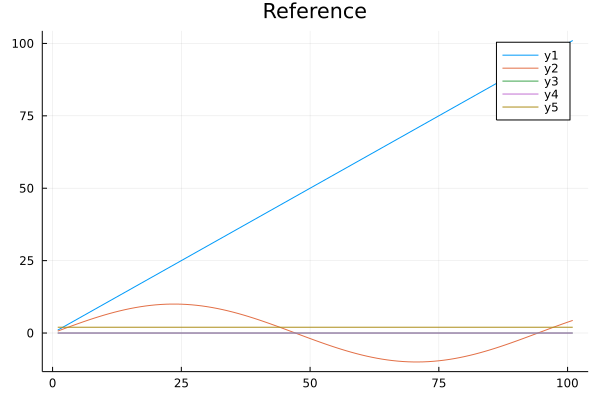

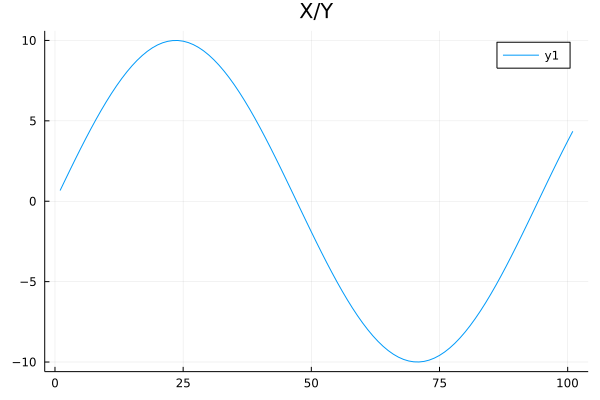

In [172]:
# Sinusoidal Y
px₀, py₀, θ₀, δ₀, v₀ = 1.0, 0.0, 0.0, 0.0, 2.0
v̄ = 0.5   # Desired velocity
const x0 = [px₀, py₀, θ₀, δ₀, v₀]
# pxs = [px₀ + (i * v̄) for i = 1:N-1 ];           pushfirst!(pxs, px₀)
# pys = [py₀ + (5 * sin(i / 15)) for i = 1:N-1];  pushfirst!(pys, py₀)
# θs  = [0 for i = 1:N-1];                         pushfirst!(θs, θ₀)
# # θs  = [atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N-1];                        pushfirst!(θs, θ₀)
# δs  = [0 for i = 1:N-1];                        pushfirst!(δs, δ₀)
# vs  = [v₀ + v̄ for i = 1:N-1];                   pushfirst!(vs, v₀)
# Xref = [ [pxs[i]; pys[i]; θs[i]; δs[i]; vs[i]] for i = 1:N]
Xref = [ [i; 10 * sin(i / 15); 0.0; 0.0; 1.0 / dt ] for i = 1:N]  

Uref = [ 0.01 * randn(2) + [0.0; 0.0] for i = 1:N-1]

# # Make a square wave / sharp turns 
# tWave, tSigns = triangleWave(N; freq = (1/20), slope = 0.1 )
# Xref = [ [i/5; tWave[i]; tSigns[i] * deg2rad(45); 0.0; (0.25 / dt) ] for i = 1:N]


Xrefm = hcat(Xref...)'
display(plot(Xrefm, title = "Reference"))
display(plot(Xrefm[:, 1], Xrefm[:, 2], title = "X/Y"))
# plot(hcat(Uref...)')

In [173]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), where 
  x is a vector of length nx, u is a vector of length nu.

returns ẋ
"""

function dynamics(x, u; L = 2, Lr = 1.5)
    # Kinematic Bicycle model (referenced to center of mass)
    
    θ, δ, v = x[3:5]   # Yaw, steering angle, velocity
    α, ϕ    = u        # Longitudinal acceleration, steering angle rate 
    
    β = atan(Lr * δ, L)
    s, c = sincos(θ + β)
    ω = v * cos(β) * tan(δ) / L 
    ẋ = v * c 
    ẏ = v * s 
    
    return [ẋ; ẏ; ω; ϕ; α]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x, u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = ForwardDiff.jacobian(_x -> rk4(_x,u,dt),x)
    B = ForwardDiff.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians

In [174]:
# TASK: Fill out the following methods (10 pts)

function stage_cost(x, u, xref, uref)
    # LQR cost at each knot point (depends on both x and u) (equation provided above)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x, xref)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X, U, Xref, Uref)
    
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:(N-1)
        J += stage_cost(X[i], U[i], Xref[i], Uref[i])
    end
    
    return J + term_cost(X[N], Xref[N])
end
        
function stage_cost_expansion(x, u, xref, uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    
    Jₓ = Q * (x - xref) 
    Jᵤ = R * (u - uref) 
    
    Jₓₓ = Q 
    Jᵤᵤ = R 
    
    # Note that ∇ₓᵤJ = 0 = ∇ᵤₓJ
    
    return Jₓₓ, Jₓ, Jᵤᵤ, Jᵤ
end

function term_cost_expansion(x, xref )
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ

    Jₓ = Qf * (x - xref)
    Jₓₓ = Qf
    
    return Jₓₓ, Jₓ
end

term_cost_expansion (generic function with 1 method)

### Forward & Backward Passes

In [175]:
"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X, U, Xref, Uref)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term   ∇ₓₓV
    p = [zeros(nx) for i = 1:N]        # cost to go linear term      ∇ₓV
    d = [zeros(nu) for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    # Initial term for P, p 
    P[end], p[end] = term_cost_expansion(X[end], Xref[end])
    
    for i = (N-1):(-1):1
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[i], U[i], Xref[i], Uref[i])
        A, B = dynamics_jacobians(X[i], U[i], dt)
        
        gx = Jx + A' * p[i + 1] 
        gu = Ju + B' * p[i + 1]
        Gxx = Jxx + A' * P[i + 1] * A 
        Guu = Juu + B' * P[i + 1] * B 
        Gxu = A' * P[i + 1]' * B            
        Gux = B' * P[i + 1] * A
        
        d[i] =  Guu \ gu       # d = Gᵤᵤ⁻¹gᵤ 
        K[i] =  Guu \ Gux      # K = Gᵤᵤ⁻¹Gᵤₓ
        
        p[i] = gx  - K[i]' * gu +  K[i]' * Guu * d[i] - Gxu * d[i]
        P[i] = Gxx + K[i]' * Guu * K[i] - Gxu * K[i] - K[i]' * Gux

        ΔJ += gu' * d[i]
    end
    
    return d, K, P, ΔJ    
end

backward_pass (generic function with 1 method)

In [176]:
function forward_pass(X, U, Xref, Uref, K, d, ΔJ; max_linesearch_iters = 10)
    
    J = trajectory_cost(X, U, Xref, Uref)  # Original cost of initial rollout
    
    α = 1.0
    
    Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
    
    num_iters = 0
    while Jn >= (J - 0.01 * α * ΔJ)
        α = 0.5 * α
        Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
        
        num_iters += 1
        if num_iters > max_linesearch_iters
            @warn "Max Linesearch Iterations reached in forward pass!"
            break
        end
    end
    
    return Xn, Un, Jn, α
end


function forward_pass_loop(X, U, Xref, Uref, K, d, α)
    N = size(X, 1)
    
    Xn, Un = deepcopy(X), deepcopy(U)
    
    for i = 1:(N - 1)
        Un[i] = U[i] - α * d[i] - K[i] * (Xn[i] - X[i])  
        Xn[i + 1] = rk4(Xn[i], Un[i], dt) 
    end
    Jn = trajectory_cost(Xn, Un, Xref, Uref)
    
    return Xn, Un, Jn 
end

forward_pass_loop (generic function with 1 method)

In [177]:
"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition Vector
    U - initial control history Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track Vector{Vector}

outputs:
    X - optimal trajectory Vector{Vector}
    U - optimal control trajectory Vector{Vector}
    K - feedback gain matrices Vector{Matrix}
    P - cost to go hessians Vector{Matrix}
    iter - iterations it took to converge Int
"""
function iLQR(x0, U, Xref, Uref; atol = 1e-4, max_iters = 100, verbose = true)
    
    # initial logging stuff 

    if verbose
        @printf "iter     J           ΔJ        |d|         α\n"
        @printf "-----------------------------------------------\n"
    end
    
    P = [zeros(nx,nx) for i = 1:N]       # cost to go quadratic term   ∇ₓₓV
    d = [zeros(nu)    for i = 1:N - 1]   # feedforward control
    K = [zeros(nu,nx) for i = 1:N - 1]   # feedback gain
    X = [zeros(nx)    for i = 1:N]
    iter = -1 

    # Generate inital X using initial U 
    X[1] = copy(x0)
    for i = 1:N - 1  
        X[i + 1] = rk4(X[i], U[i], dt) 
    end
     
    for i = 1:max_iters
        dn, Kn, Pn, ΔJ = backward_pass(X, U, Xref, Uref)
        d .= dn 
        K .= Kn 
        P .= Pn
    
        # Check for termination 
        dMax = maximum(norm.(d))  #maximum([maximum(abs.(d[j])) for j = 1:size(d, 1)])
        if dMax < atol
            println("$i  \t$ΔJ  \t$dMax  ")
            iter = i
            
#             break
            return X, U, Kn, Pn, iter

        end
        
        # Forward pass
        X, U, Jn, α = forward_pass(X, U, Xref, Uref, K, d, ΔJ)
    
        
        if verbose
            println("$i  \t$(round(Jn, digits = 5))  \t$(round(ΔJ, digits = 5))  \t$(round(dMax, digits = 5))  \t$α")
        end
        
        
        if iter == max_iters
            @warn "Max iters hit in iLQR!"
        end
    end

    return X, U, K, P, iter

end
        

iLQR

In [178]:
# RUN 
X, U, K, _, _ = iLQR(x0, Uref, Xref, Uref);

iter     J           ΔJ        |d|         α
-----------------------------------------------
1  	1134.14339  	40491.21093  	1.02926  	1.0
2  	104.88454  	2064.25284  	0.18679  	1.0
3  	102.86941  	4.06471  	0.0098  	1.0
4  	102.86362  	0.01254  	0.001  	1.0
5  	102.86356  	0.00014  	0.00013  	1.0
6  	1.912127587124874e-6  	1.5480364838243032e-5  


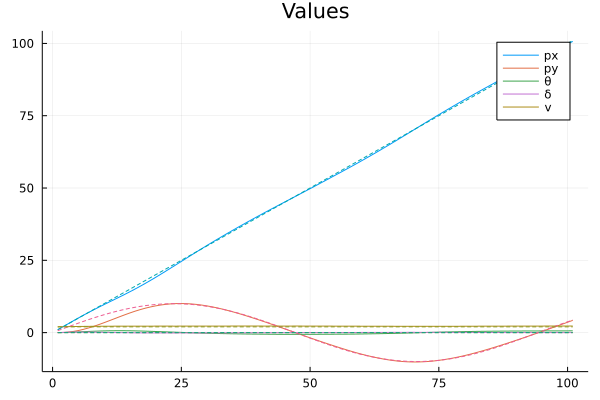

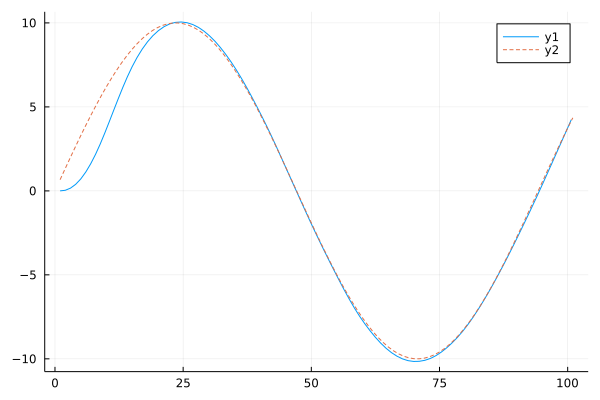

In [179]:
a = plot(hcat(X...)', label = ["px" "py" "θ" "δ" "v"])
a = plot!(hcat(Xref...)', ls = :dash, label = false, title = "Values")
display(a)

Xm = hcat(X...)'
b = plot(Xm[:, 1], Xm[:, 2])
b = plot!(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
display(b)

## MESHCAT Stuff

In [20]:
# ADD IN MESHCAT WITH COOL SHADOW FOR REAL VS REF
using RobotZoo
using StaticArrays
include("car.jl")

  Activating environment at `~/Classes/16-745_OCRL/Project/Project.toml`


plot_region!

In [61]:
model = RobotZoo.BicycleModel()
vis = initialize_visualizer(model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/benjj/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [111]:
Xref_static = [SVector{nx, Float64}(Xref[i]) for i = 1:N]
X_static    = [SVector{nx, Float64}(X[i]) for i = 1:N]

visualize!(vis, model, N * dt / 4, X_static)

In [194]:
using Colors
# using TrajOptPlots
visualize!(vis, model, N * dt / 4, X_static, Xref_static, colors=[colorant"blue", RGBA(0,0,1,0.5)])

LoadError: MethodError: no method matching visualize!(::Visualizer, ::BicycleModel, ::Float64, ::Vector{SVector{5, Float64}}, ::Vector{SVector{5, Float64}}; colors=RGBA{Float64}[RGBA{Float64}(0.0,0.0,1.0,1.0), RGBA{Float64}(0.0,0.0,1.0,0.5)])
[0mClosest candidates are:
[0m  visualize!(::Any, ::BicycleModel, ::Real, ::Any) at /home/benjj/Classes/16-745_OCRL/Project/src/car.jl:64[91m got unsupported keyword argument "colors"[39m
[0m  visualize!(::Any, ::BicycleModel, [91m::StaticVector{N, T} where {N, T}[39m) at /home/benjj/Classes/16-745_OCRL/Project/src/car.jl:52[91m got unsupported keyword argument "colors"[39m